# <font color='green'>Simulating surface codes using `stim`</font>

In [1]:
import stim
import matplotlib.pyplot as plotter
import numpy as np
from pymatching import Matching
from tqdm import tqdm
from phase_flip_rep_codes import plot_logical_error_probabilities

So far, you have learned about the surface code, its stabilizers and logical operators, and the effect of errors on the code. You have also learned about the minimum-weight perfect matching (MWPM) decoder for the surface code.

In this chapter, you will learn how to simulate the performance of the surface code under varying levels of physical noise using `stim`. As you may have noticed when we did this for repetition codes, building the syndrome extraction circuits manually is an arduous task. Many nuances need to be considered, such as avoiding qubit conflicts from overlapping parity checks and optimizing the circuit for fast execution. As you have seen in the previous chapter, even the smallest distance-3 surface codes have dense syndrome extraction circuits. `stim` handles this complexity automatically, and makes the simulations easy to run.

In addition to the syndrome extraction circuits, we also need a fast decoder to detect and correct errors across varying distances. In the code below, we achieve all of this in just a few lines by using `stim` for fast circuit simulation and `PyMatching` (for decoding).

### <font color='red'>Step 1: Generating the circuits</font>

Here we choose rotated surface code measured in the $X$-basis. As previously discussed, the rotated variant of the surface code requires fewer physical qubits per logical qubit, and is therefore better suited for execution on real quantum computers.

Unlike the case of the repetition codes, where our intent was to match `stim`'s results with our manually inserted noise models, we choose a more elaborate noise model that accounts for depolarization (randomly selected $X$, $Y$ and $Z$ gates) after Clifford gates, and before syndrome check rounds. We also consider unintended flip errors after the initialization resets, and before measurements. While we set all of these error probabilities to the same value, the component of each one is typically adjusted to fit experimental data measured directly from qubits using benchmarking techniques.

Note that we are allowing for measurement errors of the syndromes. For this reason, it's important to capture these errors by doing more than one round -- as is typical in the literature, we set the number of rounds equal to the distance.

The simulation that we are running is known as a `memory` experiment in the literature, since we initialize a logical state and check whether it has changed (due to an error) after some number of rounds.

In [2]:
p = 0.003
circuit_initial = stim.Circuit.generated("surface_code:rotated_memory_x", 
                                        distance=3, 
                                        rounds=3, 
                                        after_clifford_depolarization=p,
                                        before_round_data_depolarization=p,
                                        after_reset_flip_probability=p,
                                        before_measure_flip_probability=p)

### <font color='red'>Step 2: Generating a detector error model for the circuits</font>

Next, we generate the detector error model (DEM) in `stim`. Recall the description of DEMs from [our discussion implementing repetition codes in stim](repetition-and-shor-codes-stim.html), where you learned that it contains the impact of the errors at various locations throughout the circuit on the detectors within the circuit.

Notice, we set the `decompose_errors=True`, as we are using graph-based decoder. In cases where an error can trigger more than two detectors (forming a hyperedge), `stim` decomposes all the error mechanisms to $\textit{edge-like}$ error mechanisms. 

In [3]:
model = circuit_initial.detector_error_model(decompose_errors=True)

### <font color='red'>Step 3: Setting up a minimum-weight perfect matching decoder from the DEM</font>

The detector error model is the input to the decoder, which in this case is `PyMatching`.

In [4]:
matching = Matching.from_detector_error_model(model)

### <font color='red'>Step 4: Run the circuits and collect the syndromes (and observable flips)</font>

Now, we need to sample, say, 100000 shots from each circuit. This will allow us to see errors of order 1 in $10^5$. Each shot will contain detector
measurements, and the logical observable outcomes.

In [5]:
n_shots = 100_000
sampler = circuit_initial.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=n_shots, separate_observables=True)

### <font color='red'>Step 5: Decode the syndromes</font>

Next, we input the syndromes to the `PyMatching` decoder. 

In [6]:
predicted_observables = matching.decode_batch(syndrome)

### <font color='red'>Step 6: Determine whether our decoder was successful</font>

In order to calculate the logical error probability, we compare the predicted outcomes from `PyMatching` to the actual observables. When they do not match, we will not be able to detect that the error has occurred, and a logical error results. By tracking the total number of times the decoder failed
to predict an error, we determine the logical error probability. Note that we have assumed perfect correction when the decoder successfully identifies errors in this simulation.

In [7]:
log_errors = []
logical_error_probability = []
num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
log_errors.append(num_errors/n_shots)
logical_error_probability.append(np.array(log_errors))

## <font color='blue'>Putting it all together</font>

Now, let's put all the pieces above together to simulate the performance of the surface code for different distances and physical error probabilities.

In [8]:
num_shots = 200_000
distances = [3,5,7,9,11]
physical_error_probabilities = np.logspace(-4, -1, 20)
logical_error_probabilities = []
for distance in distances:
    print(f"Simulating distance-{distance} surface codes")
    logical_errors = []
    for p in tqdm(physical_error_probabilities):
        circuit = stim.Circuit.generated("surface_code:rotated_memory_x", 
                                        distance=distance, 
                                        rounds=distance, 
                                        after_clifford_depolarization=p,
                                        before_round_data_depolarization=p,
                                        after_reset_flip_probability=p,
                                        before_measure_flip_probability=p)
        model = circuit.detector_error_model(decompose_errors=True)
        matching = Matching.from_detector_error_model(model)
        sampler = circuit.compile_detector_sampler()
        syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)
        predicted_observables = matching.decode_batch(syndrome)
        num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
        logical_errors.append(num_errors/num_shots)
    logical_error_probabilities.append(np.array(logical_errors))

Simulating distance-3 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.53it/s]


Simulating distance-5 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Simulating distance-7 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.47s/it]


Simulating distance-9 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:56<00:00, 11.81s/it]


Simulating distance-11 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:09<00:00, 24.49s/it]


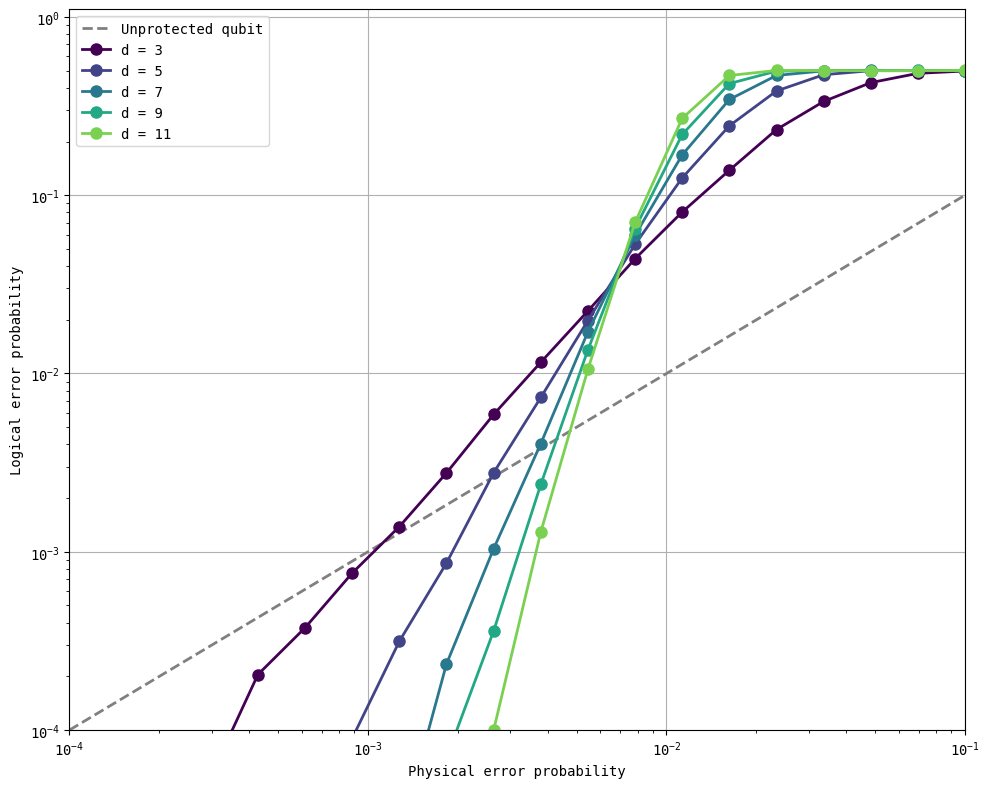

In [9]:
plot_logical_error_probabilities(distances = distances, 
                                 physical_errors = physical_error_probabilities, 
                                 all_logical_errors = logical_error_probabilities,
                                 all_analytical_errors=None, ylim = [1e-4, 1.1])

As you see in the figure above, larger distances lead to lower logical error probabilities as the physical error probabilities go down. The curves for different distances cross over at about $0.7\%$ error rate -- this is close to the threshold for a surface code reported in the literature at about $1\%$. In fact, we can rerun the simulations closer to that region to note the existence of multiple crossing points.

In [10]:
num_shots = 1_000_000
distances = [3,5,7,9,11]
physical_error_probabilities = np.linspace(4e-3, 9e-3, 20)
logical_error_probabilities = []
for distance in distances:
    print(f"Simulating distance-{distance} surface codes")
    logical_errors = []
    for p in tqdm(physical_error_probabilities):
        circuit = stim.Circuit.generated("surface_code:rotated_memory_x", 
                                        distance=distance, 
                                        rounds=distance, 
                                        after_clifford_depolarization=p,
                                        before_round_data_depolarization=p,
                                        after_reset_flip_probability=p,
                                        before_measure_flip_probability=p)
        model = circuit.detector_error_model(decompose_errors=True)
        matching = Matching.from_detector_error_model(model)
        sampler = circuit.compile_detector_sampler()
        syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)
        predicted_observables = matching.decode_batch(syndrome)
        num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
        logical_errors.append(num_errors/num_shots)
    logical_error_probabilities.append(np.array(logical_errors))

Simulating distance-3 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


Simulating distance-5 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.05s/it]


Simulating distance-7 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.21s/it]


Simulating distance-9 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:54<00:00, 26.73s/it]


Simulating distance-11 surface codes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [25:43<00:00, 77.17s/it]


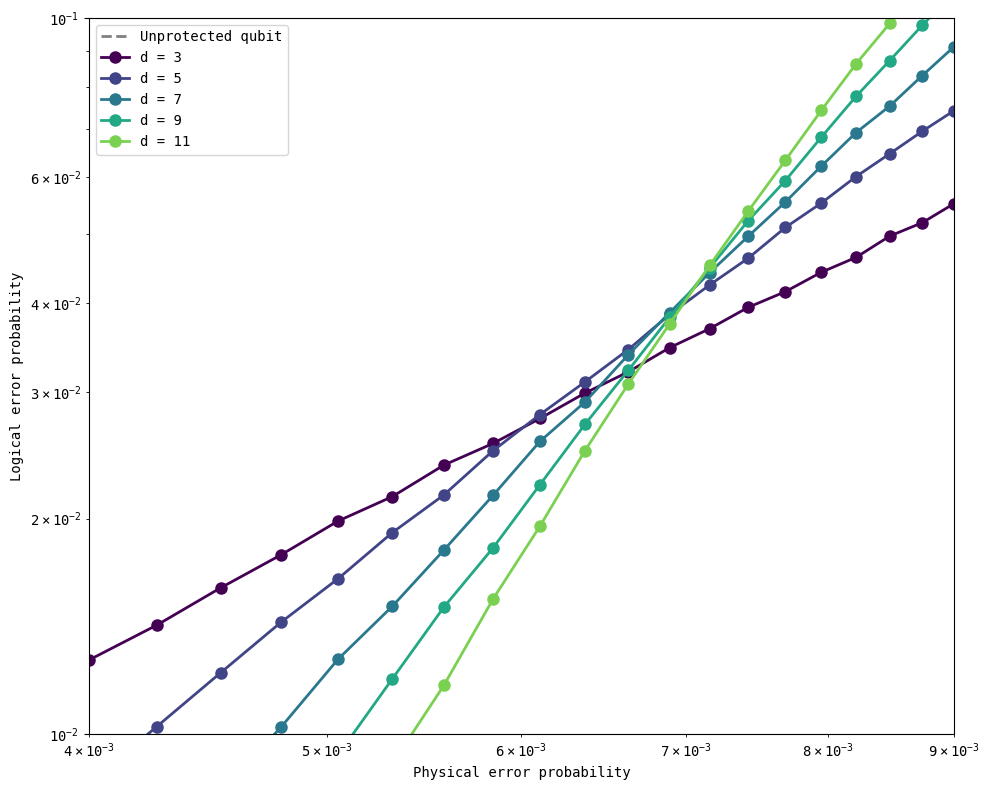

In [11]:
plot_logical_error_probabilities(distances = distances, 
                                 physical_errors = physical_error_probabilities, 
                                 all_logical_errors = logical_error_probabilities,
                                 all_analytical_errors=None, ylim = [1e-2, 1e-1])

<strong>Exercises for the reader</strong>
- Can you identify reasons why the simulation doesn't achieve a threshold closer to $1\%$? (Hint: consider the weights assigned to the various noise models in the simulation, and compare them with those used in the literature).
- Can you determine analytical expressions for the logical error probability as a function of distance and physical error probability for some of the noise models that stim provides?

### <font color='red'>Additional reading on the surface code and its threshold</font>

- [Decoding algorithms for surface code](https://arxiv.org/abs/2307.14989)
- [Surface codes: Towards practical large-scale quantum computation](https://arxiv.org/abs/1208.0928)

---
### Version History
- v0: Aug 14, 2025, [github/@ESMatekole](https:github.com/esmatekole)
- v1: Sep 12, 2025, [github/@aasfaw](https:github.com/aasfaw)